In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy

from ray_delay.device_simulator.noise_model_patch import NoiseModelPatch
from ray_delay.device_simulator.stim_simulator.memory import MemoryPatch

In [2]:
dx = 7
dz = 7
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
center_qubit = patch.patch.device[dx][dz].idx

In [3]:
from ray_delay.device_simulator.noise_model import GoogleNoiseParams
google_patch = NoiseModelPatch(MemoryPatch(dx, dz, dm), GoogleNoiseParams)

In [4]:
google_patch.patch.get_gate1_T1T2_err(0) + 1e-4

0.0009077559740291563

In [5]:
google_patch.patch.get_gate2_T1T2_err() + (10**(-2.5))

0.005143733649451556

<Axes: >

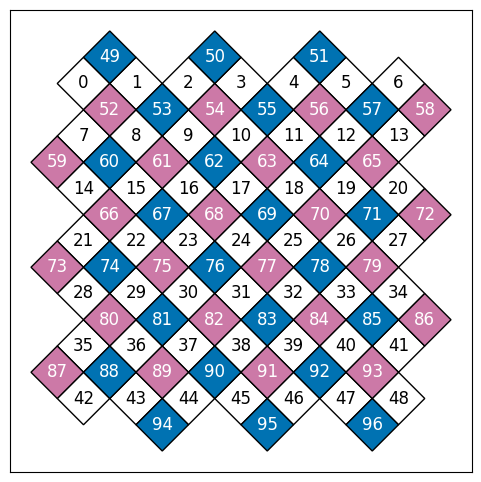

In [6]:
patch.patch.plot_qubit_vals()

In [7]:
cycles_before_ray = 10**3
cycles_after_ray = 10**4
ray_radius = 3
batch_size = 10**2

# Getting baseline and cosmic-ray-induced detector fractions

In [8]:
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [9]:
patch.reset()
baseline_err_rate = patch.patch.count_logical_errors()[0]
baseline_fractions = np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0)

patch.force_cosmic_ray(8, ray_radius)
ray_err_rate = patch.patch.count_logical_errors()[0]
ray_fractions = np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0)

In [10]:
baseline_fractions

array([0.05088567, 0.04966533, 0.04987867, 0.08525567, 0.08530683,
       0.0882205 , 0.08652217, 0.08341417, 0.083442  , 0.083561  ,
       0.0834675 , 0.08616267, 0.08635967, 0.083735  , 0.08344283,
       0.08380417, 0.08353683, 0.08633617, 0.0878735 , 0.08530683,
       0.08549533, 0.04981   , 0.04995583, 0.050753  , 0.1282775 ,
       0.12554783, 0.125902  , 0.0785505 , 0.076883  , 0.1234015 ,
       0.12311467, 0.12575233, 0.12585417, 0.12305283, 0.1229995 ,
       0.07690167, 0.07674817, 0.123408  , 0.1231255 , 0.12550017,
       0.125478  , 0.12300767, 0.1232565 , 0.07693217, 0.07806317,
       0.12562317, 0.12569867, 0.12815983])

In [11]:
baseline_fractions_labeled = {q.idx: baseline_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}
ray_fractions_labeled = {q.idx: ray_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}

In [12]:
patch.patch

----------------------------------------------------------------------------
|    |    |X 49|    |    |    |X 50|    |    |    |X 51|    |    |    |    |
----------+----+--------------+----+--------------+----+--------------------
|    |   0|    |   1|    |   2|    |   3|    |   4|    |   5|    |   6|    |
----------+----+----+----+----+----+----+----+----+----+----+----+----+-----
|    |    |Z 52|    |X 53|    |Z 54|    |X 55|    |Z 56|    |X 57|    |Z 58|
----------+----+----+----+----+----+----+----+----+----+----+----+----+-----
|    |   7|    |   8|    |   9|    |  10|    |  11|    |  12|    |  13|    |
-----+----+----+----+----+----+----+----+----+----+----+----+----+----------
|Z 59|    |X 60|    |Z 61|    |X 62|    |Z 63|    |X 64|    |Z 65|    |    |
-----+----+----+----+----+----+----+----+----+----+----+----+----+----------
|    |  14|    |  15|    |  16|    |  17|    |  18|    |  19|    |  20|    |
----------+----+----+----+----+----+----+----+----+----+----+----+----+-----

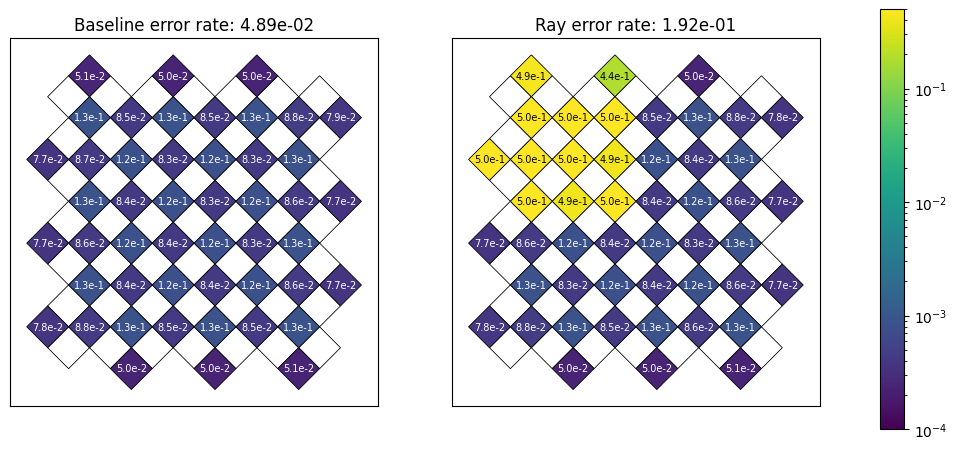

In [13]:
# todo: make function in patch that draws the patch with arbitrary values
# plotted at each qubit / connection (then we can plot the fractions by
# specifying values for only the ancilla qubits)

vmin = 1e-4
vmax = np.max(ray_fractions)
norm = mpl.colors.LogNorm
cmap = 'viridis'
fig,ax = plt.subplots(1, 2, figsize=(12,6))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = baseline_fractions[i]
patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[0], font_size=7, vmin=vmin, vmax=vmax, norm=norm, plot_text='val', cmap_name=cmap)
ax[0].set_title('Baseline error rate: {:.2e}'.format(baseline_err_rate))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = ray_fractions[i]
patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[1], font_size=7, vmin=vmin, vmax=vmax, norm=norm, plot_text='val', cmap_name=cmap)
ax[1].set_title('Ray error rate: {:.2e}'.format(ray_err_rate))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm(vmin=vmin, vmax=vmax), cmap=cmap), cax=cbar_ax)

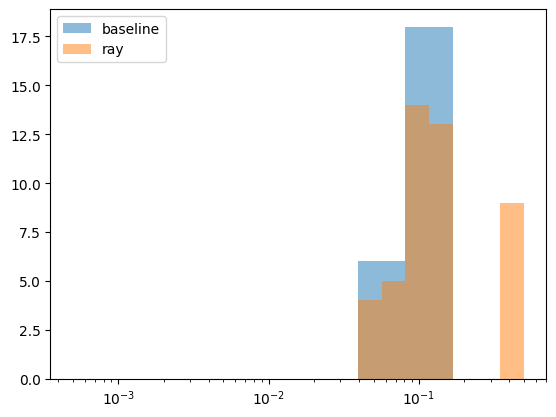

In [14]:
bins = np.geomspace(5e-4, 5e-1, 20)

plt.hist(baseline_fractions, bins, alpha=0.5, label='baseline')
plt.hist(ray_fractions, bins, alpha=0.5, label='ray')
plt.legend()
plt.xscale('log')
plt.show()

Text(0.5, 1.0, 'T1 times on cosmic ray impact')

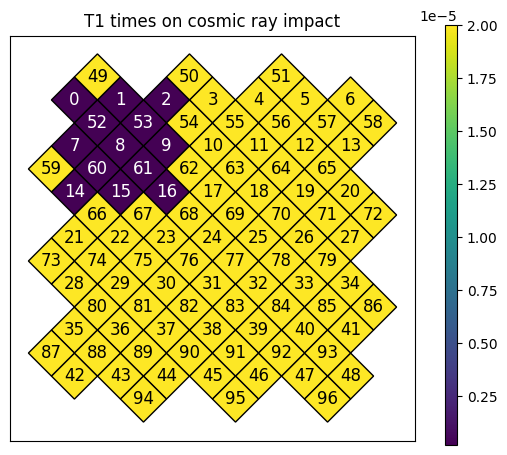

In [15]:
plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,val in patch.noise_model.get_error_val_dict()['T1'].items():
    plot_vals[i] = val
ax = patch.patch.plot_qubit_vals(plot_vals)
ax.set_title('T1 times on cosmic ray impact')

# Number of rounds required for a high-confidence prediction

### Spatio-temporal windows

Windows covering patch AND temporal syndrome history.

Parameters: temporal window $w_t$ and spatial window distance $w_s$.

In [16]:
from ray_delay.ray_detector import RayDetector

In [17]:
len(patch.patch.device)

15

In [18]:
np.array([[q.idx if q else -1 for q in row] for row in patch.patch.device])

array([[-1, -1, 49, -1, -1, -1, 50, -1, -1, -1, 51, -1, -1, -1, -1],
       [-1,  0, -1,  1, -1,  2, -1,  3, -1,  4, -1,  5, -1,  6, -1],
       [-1, -1, 52, -1, 53, -1, 54, -1, 55, -1, 56, -1, 57, -1, 58],
       [-1,  7, -1,  8, -1,  9, -1, 10, -1, 11, -1, 12, -1, 13, -1],
       [59, -1, 60, -1, 61, -1, 62, -1, 63, -1, 64, -1, 65, -1, -1],
       [-1, 14, -1, 15, -1, 16, -1, 17, -1, 18, -1, 19, -1, 20, -1],
       [-1, -1, 66, -1, 67, -1, 68, -1, 69, -1, 70, -1, 71, -1, 72],
       [-1, 21, -1, 22, -1, 23, -1, 24, -1, 25, -1, 26, -1, 27, -1],
       [73, -1, 74, -1, 75, -1, 76, -1, 77, -1, 78, -1, 79, -1, -1],
       [-1, 28, -1, 29, -1, 30, -1, 31, -1, 32, -1, 33, -1, 34, -1],
       [-1, -1, 80, -1, 81, -1, 82, -1, 83, -1, 84, -1, 85, -1, 86],
       [-1, 35, -1, 36, -1, 37, -1, 38, -1, 39, -1, 40, -1, 41, -1],
       [87, -1, 88, -1, 89, -1, 90, -1, 91, -1, 92, -1, 93, -1, -1],
       [-1, 42, -1, 43, -1, 44, -1, 45, -1, 46, -1, 47, -1, 48, -1],
       [-1, -1, -1, -1, 94, -1, -1

In [19]:
ray_detector = RayDetector(patch.patch.device, 100, 10, 6, 0.99, False)

In [20]:
ray_detector._windows[0]

[49, 50, 52, 53, 54, 59, 60, 61, 62, 66, 67, 68]

Metrics we care about for detection scheme:

- Confidence percentile ~= false negative rate (up to integer rounding)
    - Derived param: expected number of cycles / distillations / seconds per false trigger
- Average-case time-to-detection of ray
- Chance that it takes longer than one full distillation to detect a ray (~=
  chance of a bad T state being produced)
- Compute and memory overhead

In [29]:
cycles_per_distillation = 6*dm
max_latency = cycles_per_distillation

thresholds = [0.99, 0.999, 0.9999, 0.99999, 0.999999]
for temporal_window_size in [10,20,50,100]:
    for spatial_size in [1,6,14]:

        # just using it for its windows
        ray_detector = RayDetector(patch.patch.device, 100, 10, spatial_size, 0.99, False)

        signal_rates = np.zeros((len(thresholds), max_latency, len(ray_detector._windows)))
        false_positive_rates = np.zeros((len(thresholds), max_latency, len(ray_detector._windows)))
        detection_thresholds = np.zeros((len(thresholds), max_latency, len(ray_detector._windows)))
        for i,threshold in enumerate(thresholds):
            for latency in range(1, max_latency+1):
                j = latency - 1
                for k,window in enumerate(ray_detector._windows):
                    baseline_mean = np.mean([baseline_fractions_labeled[q] for q in window]) # mean per qubit per round
                    ray_mean = np.mean([ray_fractions_labeled[q] for q in window])

                    # threshold of detections where we say it is outside of the baseline regime
                    detection_threshold = scipy.stats.binom.ppf(threshold, len(window)*temporal_window_size, baseline_mean)
                    detection_thresholds[i,j,k] = detection_threshold

                    # chance that baseline generates more than threshold detections
                    false_positive = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, baseline_mean)
                    false_positive_rates[i,j,k] = false_positive
                
                    # chance that ray is detected
                    if latency <= temporal_window_size:
                        windowed_syndrome_rate = baseline_mean*(1-latency/temporal_window_size) + ray_mean*(latency/temporal_window_size)
                    else:
                        windowed_syndrome_rate = ray_mean
                    detection_prob = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, windowed_syndrome_rate)
                    signal_rates[i,j,k] = detection_prob

        cumulative_signal_rates = 1-np.cumprod(np.prod(1-signal_rates, axis=2), axis=1)
        cumulative_false_positive_rates = 1-np.cumprod(np.prod(1-false_positive_rates, axis=2), axis=1)

        made_label = False
        for j in range(max_latency):
            if j % cycles_per_distillation == 0:
                if made_label:
                    plt.axvline(j, color='k', linestyle='-', alpha=0.5)
                else:
                    plt.axvline(j, color='k', linestyle='-', alpha=0.5, label='Distillation')
                    made_label = True
        
        plt.plot([-1,-1], [1,1], '--', color='gray', label='False positive (with no ray)')

        print(temporal_window_size, spatial_size, detection_thresholds[:,0,0])
        plt.plot(cumulative_signal_rates.T, '-', label=[f'conf={c}, avg. thresh={np.mean(detection_thresholds[i,0]):0.2f}' for i,c in enumerate(thresholds)])
        plt.gca().set_prop_cycle(None)
        plt.plot(cumulative_false_positive_rates.T, '--')
        plt.legend()
        plt.xlim(0,max_latency)
        plt.title(f'Temporal window {temporal_window_size}, spatial window {spatial_size}\nAvg. syndromes per window {np.mean([len(w) for w in ray_detector._windows]):0.2f}/{temporal_window_size*np.mean([len(w) for w in ray_detector._windows]):0.2f}')
        plt.savefig(f'wt_{temporal_window_size}_ws_{spatial_size}.png')
        plt.close()


10 1 [3. 4. 4. 5. 6.]
10 6 [19. 22. 25. 27. 29.]
10 14 [61. 66. 71. 75. 79.]
20 1 [4. 5. 6. 7. 8.]
20 6 [34. 38. 41. 44. 47.]
20 14 [113. 120. 126. 132. 137.]
50 1 [ 7.  8. 10. 11. 12.]
50 6 [74. 80. 85. 90. 94.]
50 14 [261. 273. 282. 291. 298.]
100 1 [11. 13. 15. 17. 18.]
100 6 [138. 147. 154. 160. 165.]
100 14 [502. 518. 531. 543. 554.]


## Investigating specific window size

In [22]:
cycle_time = patch.patch.cycle_time
offline_time = 50e-3
# if we want to add X overhead, need (num_cycles + num_offline*offline_time) / num_cycles = X
# i.e. X*num_cycles = num_cycles + num_offline*offline_time
# i.e. X = 1 + num_offline/num_cycles * offline_time
# i.e. false_pos_rate = num_offline/num_cycles = (X-1)/offline_time

time_overhead = 1.1
print((time_overhead-1)/offline_time)

2.0000000000000018


In [23]:
cycles_per_distillation = 6*dm
max_latency = cycles_per_distillation

thresholds = [0.99, 1-1e-4, 1-1e-7, 1-1e-9]
temporal_window_size = 10
spatial_size = 6

# just using it for its windows
ray_detector = RayDetector(patch.patch.device, 100, 10, spatial_size, 0.99, False)

signal_rates = np.zeros((len(thresholds), max_latency, len(ray_detector._windows)), np.longdouble)
syndrome_rates = np.zeros((len(thresholds), max_latency, len(ray_detector._windows)), np.longdouble)
false_positive_rates = np.zeros((len(thresholds), max_latency, len(ray_detector._windows)), np.longdouble)
detection_thresholds = np.zeros((len(thresholds), max_latency, len(ray_detector._windows)), np.longdouble)
for i,threshold in enumerate(thresholds):
    for latency in range(1, max_latency+1):
        j = latency - 1
        window_false_positive_rates = []
        for k,window in enumerate(ray_detector._windows):
            baseline_mean = np.mean([baseline_fractions_labeled[q] for q in window]) # mean per qubit per round
            ray_mean = np.mean([ray_fractions_labeled[q] for q in window])

            # threshold of detections where we say it is outside of the baseline regime
            detection_threshold = scipy.stats.binom.ppf(threshold, len(window)*temporal_window_size, baseline_mean)
            detection_thresholds[i,j,k] = detection_threshold

            # chance that baseline generates more than threshold detections
            false_positive = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, baseline_mean)
            # false_positive_rates[i,j,k] = false_positive
            window_false_positive_rates.append(false_positive)
        
            # chance that ray is detected
            if latency <= temporal_window_size:
                windowed_syndrome_rate = baseline_mean*(1-latency/temporal_window_size) + ray_mean*(latency/temporal_window_size)
            else:
                windowed_syndrome_rate = ray_mean
            syndrome_rates[i,j,k] = windowed_syndrome_rate
            detection_prob = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, windowed_syndrome_rate)
            signal_rates[i,j,k] = detection_prob
        # funky math to make float precision better - could technically just do
        # 1 - np.prod(1-window_false_positive_rates, axis=0) but this is more
        # accurate for very small rates because float is more precise near 0.
        false_positive_rates[i,j] = np.prod(window_false_positive_rates)

cumulative_no_signal_rates = np.cumprod(np.prod(1-signal_rates, axis=2), axis=1)
cumulative_signal_rates = 1 - cumulative_no_signal_rates
cumulative_no_signal_rates_baseline = np.cumprod(np.prod(1-false_positive_rates, axis=2), axis=1)
cumulative_false_positive_rates = 1 - cumulative_no_signal_rates_baseline

In [24]:
np.mean(detection_thresholds, axis=2)[:,0]

array([20.17283951, 25.71604938, 32.17283951, 35.35802469], dtype=float64)

In [25]:
np.prod(1-false_positive_rates, axis=2)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float64)

In [26]:
cumulative_no_signal_rates

array([[8.88070680e-002, 1.41077523e-005, 4.83919653e-015,
        1.96871829e-033, 4.85517901e-064, 4.31355160e-110,
        9.71187835e-175, 4.34635213e-261, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [9.32465495e-001, 4.15873679e-001, 7.78016088e-003,
        7.40776916e-008, 1.21640523e-018, 6.18434948e-038,
        1.30722726e-068, 1.32437013e-113, 6.51717099e-1

In [27]:
for thresh in thresholds:
    false_positive_rate = np.prod(1-false_positive_rates, axis=2)[i,-1]
    prob_no_signal = scipy.stats.binom.pmf(0, len(ray_detector._windows)*temporal_window_size, baseline_mean)

In [28]:
# This cell takes about 11 minutes to run

patch.noise_model.reset()
baseline_err_rate = patch.patch.count_logical_errors()[0]
baseline_syndromes = patch.patch.count_detection_events(cycles_before_ray, return_full_data=True)[3]

for i in range(cycles_before_ray // batch_size):
    # so that noise model saves its values
    patch.step(0)

patch.force_cosmic_ray(center_qubit, ray_radius)
err_rates = [baseline_err_rate]*(cycles_before_ray // batch_size)
syndromes = [baseline_syndromes]
for i in range(cycles_after_ray // batch_size):
    err_rates.append(patch.patch.count_logical_errors()[0])
    syndromes.append(patch.patch.count_detection_events(batch_size, return_full_data=True)[3])
    patch.step(patch.patch.cycle_time()*batch_size)

KeyboardInterrupt: 

In [ ]:
patch.noise_model.active_cosmic_rays[0].affected_qubits

[17, 9, 10, 11, 48, 49, 16, 18, 54, 55, 23, 24, 25]

In [ ]:
tlist = np.cumsum([patch.patch.cycle_time()*batch_size]*len(err_rates))
all_syndromes = np.concatenate(syndromes)

In [ ]:
averaged_syndromes = [np.mean(all_syndromes[i*batch_size:(i+1)*batch_size]) for i in range(all_syndromes.shape[0]//batch_size)]

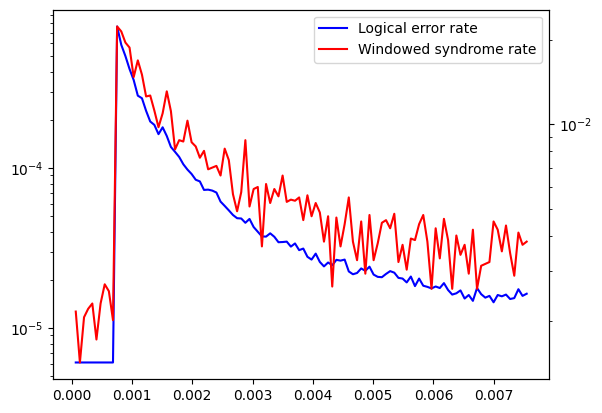

In [ ]:
fig,ax = plt.subplots()
ax1 = ax.twinx()

ln = ax.plot(tlist, err_rates, c='b', label='Logical error rate')
ln1 = ax1.plot(tlist, averaged_syndromes, c='r', label='Windowed syndrome rate')

# shared legend
lns = ln+ln1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_yscale('log')
ax1.set_yscale('log')

Should somehow quantify how much of an increased logical error rate we can
reliably detect. Find relationship between logical error rate and average
syndrome rate across whole patch, for cosmic rays at random locations on chip.

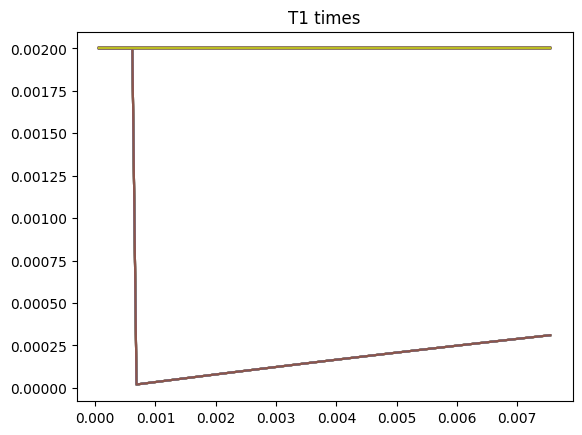

In [ ]:
t1_vals = np.array([[vals['T1'][q] for q in range(len(patch.patch.all_qubits))] for vals in patch.noise_model.error_val_history[1:]])
# t1_vals = t1_vals[[0]*(cycles_before_ray // batch_size) + list(range(cycles_after_ray // batch_size))]

plt.plot(tlist, t1_vals)
plt.title('T1 times')
plt.show()